In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F


/home/sasha/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:

class Classifier(nn.Module): 
    def __init__(self, classes: int = 10): 
        super().__init__() 
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) 
        self.pool = nn.MaxPool2d(2, 2) 
        #self.dropout1 = nn.Dropout2d(0.25) 
        #self.dropout2 = nn.Dropout2d(0.5) 
        self.fc1 = nn.Linear(64 * 7 * 7, 128) 
        self.fc2 = nn.Linear(128, classes) 
  
    def forward(self, x): 
        x = self.pool(F.relu(self.conv1(x))) 
        #x = self.dropout1(x) 
        x = self.pool(F.relu(self.conv2(x))) 
        #x = self.dropout2(x) 
        x = x.view(-1, 64 * 7 * 7) 
        x = F.relu(self.fc1(x)) 
        x = self.fc2(x) 
        return x

In [3]:
from src.methods.bayes.variational.distribution import LogUniformVarDist
from src.methods.bayes.variational.net_distribution import VarBayesModuleNetDistribution
from src.methods.bayes.base.net_distribution import BaseNetDistributionPruner

In [4]:
p = nn.Parameter(torch.tensor([0.0, 1.0]))
LogUniformVarDist.from_parameter(p)

LogUniformVarDist(param_mus: torch.Size([2]), param_std_log: torch.Size([2]), scale_mus: torch.Size([2]), scale_alphas_log: torch.Size([2]))

In [5]:
from src.methods.bayes.variational.net import LogUniformVarBayesModule, VarBayesModuleNet
from src.methods.bayes.variational.optimization import LogUniformVarKLLoss


In [6]:
test_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [7]:
module = Classifier()

In [8]:
#bayes_model = BayesModule(module)
var_module = LogUniformVarBayesModule(module)
bayes_model = VarBayesModuleNet(module, nn.ModuleList([var_module]))

In [9]:
print(bayes_model)

VarBayesModuleNet(
  (module_list): ModuleList(
    (0): LogUniformVarBayesModule(
      (posterior_params): ParameterList(
          (0): Object of type: ParameterDict
          (1): Object of type: ParameterDict
          (2): Object of type: ParameterDict
          (3): Object of type: ParameterDict
          (4): Object of type: ParameterDict
          (5): Object of type: ParameterDict
          (6): Object of type: ParameterDict
          (7): Object of type: ParameterDict
        (0): ParameterDict(
            (param_mus): Parameter containing: [torch.FloatTensor of size 32x1x3x3]
            (param_std_log): Parameter containing: [torch.FloatTensor of size 32x1x3x3]
            (scale_alphas_log): Parameter containing: [torch.FloatTensor of size 32x1x3x3]
            (scale_mus): Parameter containing: [torch.FloatTensor of size 32x1x3x3]
        )
        (1): ParameterDict(
            (param_mus): Parameter containing: [torch.FloatTensor of size 32]
            (param_std_lo

In [10]:
cnt = 0
for i, p in enumerate(bayes_model.parameters()):
    cnt += 1
print(cnt)

32


In [11]:
a = torch.tensor([[0, 2.], [3, 0]])
b =  torch.tensor([1., 1.])
a_s = a.to_sparse()
print(a_s @ b)

tensor([2., 3.])


In [12]:
optimizer = optim.Adam(bayes_model.parameters(), lr=0.1)

In [13]:
bayes_model.prior

{'conv1.weight': None,
 'conv1.bias': None,
 'conv2.weight': None,
 'conv2.bias': None,
 'fc1.weight': None,
 'fc1.bias': None,
 'fc2.weight': None,
 'fc2.bias': None}

In [14]:
image, label = test_dataset[10]
y = bayes_model(torch.ones_like(image))
kl_loss = LogUniformVarKLLoss()
bayes_model.prior
out = y.sum() + kl_loss(bayes_model.weights, bayes_model.posterior, bayes_model.prior)
optimizer.zero_grad() 
out.backward() 
optimizer.step() 

In [15]:
net_distributon = VarBayesModuleNetDistribution(bayes_model.base_module, bayes_model.posterior)
net_distributon_pruner = BaseNetDistributionPruner(net_distributon)
net_distributon.set_map_params()
net_distributon_pruner.prune(-2.2)
#get basic model for evaluation
eval_model = net_distributon.get_model()

In [16]:
print(eval_model.conv1.weight)

Parameter containing:
tensor([[[[-0.1157, -0.1915, -0.0390],
          [ 0.0499,  0.0941,  0.0694],
          [-0.0231,  0.1249, -0.1564]]],


        [[[ 0.1365,  0.0347,  0.0062],
          [ 0.1595, -0.2144, -0.0786],
          [-0.1040,  0.1674, -0.1165]]],


        [[[-0.1533,  0.0408, -0.1981],
          [-0.0988, -0.0325,  0.1264],
          [ 0.0275, -0.1943,  0.1285]]],


        [[[ 0.1615, -0.0594, -0.1627],
          [-0.0341,  0.1596,  0.1249],
          [-0.0046,  0.0860,  0.1796]]],


        [[[-0.1408, -0.0823,  0.1462],
          [ 0.1344, -0.1075, -0.0760],
          [-0.0581,  0.0341,  0.0704]]],


        [[[-0.2011,  0.0503, -0.1696],
          [-0.0218, -0.0840,  0.2129],
          [ 0.0756, -0.0333, -0.1517]]],


        [[[ 0.1688, -0.0517, -0.0203],
          [-0.0123, -0.0083, -0.0450],
          [ 0.0355,  0.0382, -0.2248]]],


        [[[ 0.0965,  0.0807,  0.0322],
          [ 0.2263, -0.2321, -0.0151],
          [-0.1786,  0.0161,  0.0851]]],


        [[

In [17]:
bayes_model.state_dict()

OrderedDict([('module_list.0.posterior_params.0.param_mus',
              tensor([[[[-0.1157, -0.1915, -0.0390],
                        [ 0.0499,  0.0941,  0.0694],
                        [-0.0231,  0.1249, -0.1564]]],
              
              
                      [[[ 0.1365,  0.0347,  0.0062],
                        [ 0.1595, -0.2144, -0.0786],
                        [-0.1040,  0.1674, -0.1165]]],
              
              
                      [[[-0.1533,  0.0408, -0.1981],
                        [-0.0988, -0.0325,  0.1264],
                        [ 0.0275, -0.1943,  0.1285]]],
              
              
                      [[[ 0.1615, -0.0594, -0.1627],
                        [-0.0341,  0.1596,  0.1249],
                        [-0.0046,  0.0860,  0.1796]]],
              
              
                      [[[-0.1408, -0.0823,  0.1462],
                        [ 0.1344, -0.1075, -0.0760],
                        [-0.0581,  0.0341,  0.0704]]],
              


In [18]:
print(bayes_model(torch.zeros_like(image)))
#print(bayes_model(torch.zeros_like(image), sample = False))
print(module(torch.zeros_like(image)))

tensor([[ 0.0717, -0.4550, -0.2116, -0.3825,  0.1673,  0.2028, -0.2482,  0.0824,
         -0.1969,  0.2568]], grad_fn=<AddmmBackward0>)
tensor([[ 0.0717, -0.4550, -0.2116, -0.3825,  0.1673,  0.2028, -0.2482,  0.0824,
         -0.1969,  0.2568]], grad_fn=<AddmmBackward0>)


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [20]:
from src.methods.bayes.variational.trainer import VarBayesTrainer, VarTrainerParams, Beta_Scheduler_Plato, CallbackLossAccuracy
from src.methods.report.base import ReportChain
from src.methods.report.variational import VarBaseReport

In [21]:
beta = Beta_Scheduler_Plato()

In [22]:
x = torch.tensor([1., 2.], requires_grad=True)
print(x)
y = x ** 2
print(y)
z = nn.Parameter(y)
loss = z.sum()
print(z)
loss .backward()
print(z)
print(x)

tensor([1., 2.], requires_grad=True)
tensor([1., 4.], grad_fn=<PowBackward0>)
Parameter containing:
tensor([1., 4.], requires_grad=True)
Parameter containing:
tensor([1., 4.], requires_grad=True)
tensor([1., 2.], requires_grad=True)


In [23]:
BATCH_SIZE=1000
EPOCHS=4000
LR = 5e-4 #5e-4
# Split the training set into training and validation sets 
VAL_PERCENT = 0.2 # percentage of the data used for validation 
SAMPLES = 10
BETA = 0.01 #5e-5
BETA_FAC = 5e-1
PRUNE = 1.9#1.99, 2.1
PLATO_TOL = 20

base_module = Classifier()
var_module = LogUniformVarBayesModule(base_module)
model = VarBayesModuleNet(base_module, nn.ModuleList([var_module]))


optimizer = optim.Adam(model.parameters(), lr=LR)

fit_loss = nn.CrossEntropyLoss() 
kl_loss = LogUniformVarKLLoss()

beta = Beta_Scheduler_Plato(BETA, BETA_FAC, PLATO_TOL)
beta_KL = Beta_Scheduler_Plato(beta.beta, 1 / BETA_FAC, PLATO_TOL, ref = beta, threshold=1e-4)
def post_train_step(trainer: VarTrainerParams, train_result: VarBayesTrainer.TrainResult):
    beta.step(train_result.fit_loss)
    beta_KL.step(train_result.dist_loss)
    trainer.params.beta = float(beta)
    
#print(model.base_module.state_dict().keys())
val_size    = int(VAL_PERCENT * len(train_dataset)) 
train_size  = len(train_dataset) - val_size 
#ВЫНЕСТИ В ПАРАМЕТРЫ ТРЕЙНЕРА
t_dataset, v_dataset = torch.utils.data.random_split(train_dataset,  
                                                        [train_size,  
                                                            val_size]) 

# Create DataLoaders for the training and validation sets 
train_loader = torch.utils.data.DataLoader(t_dataset,  
                                        batch_size=BATCH_SIZE,  
                                        shuffle=True, 
                                        pin_memory=True) 
eval_loader = torch.utils.data.DataLoader(v_dataset,  
                                        batch_size=BATCH_SIZE,  
                                        shuffle=False, 
                                        pin_memory=True) 

model.to(device) 
train_params = VarTrainerParams(EPOCHS, optimizer,fit_loss, kl_loss, SAMPLES, PRUNE, BETA, {'accuracy': CallbackLossAccuracy()})
trainer = VarBayesTrainer(train_params, ReportChain([VarBaseReport()]), train_loader, eval_loader, [post_train_step])
trainer.train(model)

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch [1/4000],Loss:3039765.75, KL Loss: 3039763.5. FitLoss: 2.301588773727417,Accuracy:0.10582500000000002,Validation Loss:3038290.5,Validation Accuracy:0.197, Prune parameters: 0.0/421642,Beta: 0.01
Epoch [2/4000],Loss:3037144.75, KL Loss: 3037142.5. FitLoss: 2.297849416732788,Accuracy:0.11633750000000002,Validation Loss:3035672.0,Validation Accuracy:0.191, Prune parameters: 0.0/421642,Beta: 0.01
Epoch [3/4000],Loss:3034528.0, KL Loss: 3034525.75. FitLoss: 2.297004222869873,Accuracy:0.11617499999999999,Validation Loss:3033057.25,Validation Accuracy:0.119, Prune parameters: 0.0/421642,Beta: 0.000625


KeyboardInterrupt: 

In [ ]:
base_module.state_dict()

OrderedDict()

In [ ]:
torch.save(model.state_dict(), 'model_bayes.pt' )

In [ ]:
model.prune({'threshold': 1.9})
print(model.prune_stats())

tensor(409356., device='cuda:0')


In [ ]:
model.prune([{'threshold': -2.2}])
print(model.prune_stats())

tensor(47343., device='cuda:0')


In [ ]:
module = Classifier()
var_module = LogUniformVarBayesModule(module)
model = VarBayesModuleNet(module, nn.ModuleList([var_module]))

In [ ]:
model.state_dict()

OrderedDict([('module_list.0.posterior_params.0.param_mus',
              tensor([[[[-0.2737, -0.0213, -0.1784],
                        [-0.0449,  0.1339,  0.2884],
                        [ 0.1757,  0.2454,  0.0318]]],
              
              
                      [[[-0.2829,  0.1125,  0.2672],
                        [-0.0329,  0.1954,  0.2326],
                        [-0.0857, -0.2534,  0.0893]]],
              
              
                      [[[ 0.1525,  0.0669, -0.2533],
                        [-0.1758,  0.1672,  0.1206],
                        [ 0.0153,  0.1936, -0.3305]]],
              
              
                      [[[ 0.0107,  0.3182,  0.2102],
                        [-0.1029,  0.3132, -0.2125],
                        [-0.2650,  0.0061,  0.2422]]],
              
              
                      [[[-0.1922,  0.1445, -0.1445],
                        [-0.1862, -0.1703,  0.1814],
                        [-0.3061, -0.1629,  0.1818]]],
              


In [ ]:
model.load_state_dict(torch.load('model_bayes.pt'))
image1, label1 = test_dataset[10]
image2, label2 = test_dataset[11]
model(image1)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
val_loss = 0.0
val_acc = 0.0
PRUNE = 1.0
test_loader = torch.utils.data.DataLoader(test_dataset,  
                                         batch_size=BATCH_SIZE,  
                                         shuffle=False, 
                                         pin_memory=True) 
kl_loss = LogUniformVarKLLoss()
trainer.params.prune_threshold = PRUNE
test_result = trainer.eval(model, test_loader)
acc = test_result.custom_losses['val_accuracy']
print(f'Loss:{test_result.val_loss}, KL Loss: {test_result.dist_loss}, FitLoss: {test_result.fit_loss}, Accuracy {acc}, Prune parameters: {test_result.cnt_prune_parameters}/{test_result.cnt_params}')

Loss:16906.90234375, KL Loss: 1690681.375, FitLoss: 0.09073139727115631, Accuracy 0.98, Prune parameters: 221821.0/421642


In [ ]:
model.to(device=device)
model.prune({'threshold': 1.0})
model.set_map_params()


In [ ]:
print(model.base_module.conv1.weight)

Parameter containing:
tensor([[[[ 4.2992e-03, -5.4342e-01, -0.0000e+00],
          [ 3.9089e-01, -0.0000e+00, -0.0000e+00],
          [ 8.2518e-01,  3.0815e-01, -2.3478e-02]]],


        [[[ 9.8153e-02,  0.0000e+00, -0.0000e+00],
          [ 4.4879e-01,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00, -0.0000e+00]]],


        [[[-1.4131e+00, -7.5729e-01, -0.0000e+00],
          [ 2.0788e-01,  4.6619e-01,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  2.6288e-01]]],


        [[[ 0.0000e+00,  9.8380e-01,  3.4592e-01],
          [-0.0000e+00,  4.0430e-01,  0.0000e+00],
          [-8.4115e-01, -3.8792e-01, -1.5979e-01]]],


        [[[ 2.0565e-01,  0.0000e+00,  2.3229e-01],
          [ 0.0000e+00,  6.6020e-01,  0.0000e+00],
          [-0.0000e+00, -0.0000e+00, -3.2411e-01]]],


        [[[-0.0000e+00,  3.8068e-01,  0.0000e+00],
          [-1.7023e-03,  7.2274e-01,  1.6451e-01],
          [-2.6313e-01,  0.0000e+00, -8.0280e-02]]],


        [[[ 0.0000e+00,  7.1311e-01,

Label: 5


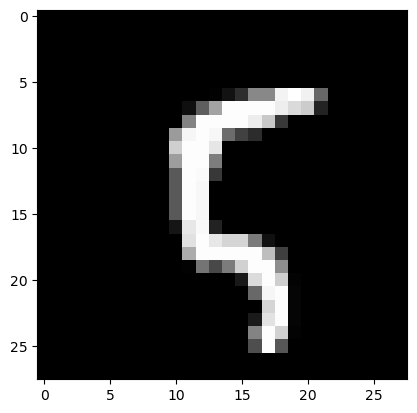

In [ ]:
image, label = test_dataset[100]
plt.imshow(image.permute(1, 2, 0), cmap = 'gray')
print('Label:', label)

In [ ]:
torch.max(model(image.cuda()).data, 1)

torch.return_types.max(
values=tensor([2.1405], device='cuda:0'),
indices=tensor([5], device='cuda:0'))